# ECON 323 Final Project: Predicting Price Ranges of Airbnb's in NYC

Written by:
- Brian Zeng (38082186) (section 004)
- Joyce Lu (69331106) (section 004)


## Introduction
In this project, we will aim to predict price ranges of airbnbs in NYC. As suggested in our project feedback, we will be making minimal use of existing package models. We hope to further explore the space of Machine Learning by instead coding our own random forest and using methods beyond the scope of this course. We have decided to use a random forest as it is one of the best out of the box classification methods. Other methods we considered were Naive Bayes and KNN, but random forests also provide a more incremental approach which is desirable for the purpose of this project. We were inspired to do price predictions as one of us was recently looking at airbnbs in Manhattan for a trip in the summer and surprisingly there was a dataset on this exact information. **Note: we pivoted from our inital sleep study test because after further investigation it seems it was an auto-generated dataset with no interesting findings.**

Below is a high-level outline of our procedure
1. Pre-process the data
2. Create test and training sets
3. Build a normal decision tree
4. Extend the normal decision trees to create random trees 
5. Analyze our results 
6. Discussion about the shortcomings of our model and/or experimentation process
7. Compare with sklearn

#### Packages

In [383]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing, utils

%matplotlib inline

## Dataset

We will be utilizing a dataset with [New York City Airbnb Data](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv). We will first do some preprocessing of the data to make it model compatible such as removing some columns and categorizing our target label "price". We will be categorizing it to approach it with classification methods and because price categories are intuitively reasonable. To simplify things we will also only look at Manhattan airbnbs from 100 to 500 dollars. Then we will shuffle and seperate the dataset to our test and training sets.

In [369]:
df = pd.read_csv("AB_NYC_2019.csv")
df = df[df["neighbourhood_group"] == "Manhattan"]
df = df[(df["price"] >= 100) & (df["price"] <= 700)]
df = df.sample(n=2500) # only take 2500 otherwise takes too long
df = df.drop(["id", "name" , "host_id", "host_name", "last_review"], axis=1)
df = df.fillna(0)

# categorize price ranges
bins = [100,150,200,250,300,350,400,450,500]
labels = np.array(range(len(bins)-1))
class_count = len(labels)
df['price'] = pd.cut(df['price'], bins=bins, labels=labels)

# give labels to string fields
le = preprocessing.LabelEncoder()
le.fit(df["neighbourhood_group"])
df["neighbourhood_group"] = le.transform(df["neighbourhood_group"])
le.fit(df["neighbourhood"])
df["neighbourhood"] = le.transform(df["neighbourhood"])
le.fit(df["room_type"])
df["room_type"] = le.transform(df["room_type"])
le.fit(df["room_type"])
df["room_type"] = le.transform(df["room_type"])
le.fit(df["price"])
df["price"] = le.transform(df["price"])

print(df.head())

num_training = int(len(df)*0.8)
X = df.drop(["price"], axis=1)
y = df["price"]
X, y = utils.shuffle(X, y, random_state=42)
n, d = X.shape
X_train = X.iloc[:num_training,:].values
X_test = X.iloc[num_training:,:].values
y_train = y.iloc[:num_training].values
y_test = y.iloc[num_training:].values



       neighbourhood_group  neighbourhood  latitude  longitude  room_type  \
7679                     0             17  40.75245  -73.97342          1   
1319                     0              5  40.73047  -73.98229          0   
540                      0             11  40.76415  -73.99067          0   
6466                     0             28  40.77429  -73.95628          0   
24798                    0             29  40.77476  -73.98947          0   

       price  minimum_nights  number_of_reviews  reviews_per_month  \
7679       3               1                  6               0.12   
1319       8               5                  6               0.07   
540        0               1                122               1.29   
6466       2               7                  8               0.16   
24798      4              30                  8               0.38   

       calculated_host_listings_count  availability_365  
7679                                3                 0  


#### Baseline
This is our baseline training and test accuracy which is just picking the mode

In [361]:
baseline_train = len(y_train[y_train == np.argmax(np.bincount(y_train))])/len(y_train) 
baseline_test = len(y_test[y_test == np.argmax(np.bincount(y_test))])/len(y_test) 
print(f"baseline training accuracy: {baseline_train}")
print(f"baseline test accuracy: {baseline_test}")

baseline training accuracy: 0.314
baseline test accuracy: 0.316


## Creating the Decision Stump
We will use the most common splitting criterion of information gain which aims to select the feature that reduces entropy. This will be the most atomic unit that we construct our Decision Tree from.

In [370]:
from scipy.stats import entropy, mode

class DecisionStump:
    y_hat_yes = None
    y_hat_no = None
    j_best = None
    t_best = None

    def getProbs(self, n, classCount, count):
        if(n == 0): return []
        p = np.zeros(classCount)
        for i in range(classCount):
            p[i] = count[i]/n

        p[p == 0] = 1e-9 # fixes divide by 0 error in entropy function
        return p
    
    def mode(self, y_subset):
        if(len(y_subset) == 0): return -1
        return np.argmax(np.bincount(y_subset))

    def fit(self, X, y, feature_space=None):
        n, d = X.shape

        # Get an array with the number of 0's, number of 1's, etc.
        count = np.bincount(y, minlength=class_count)

        # Get the index of the largest value in count.
        # Thus, y_mode is the mode (most popular value) of y
        y_mode = np.argmax(count)

        self.y_hat_yes = y_mode

        # If all the labels are the same, no need to split further
        if np.unique(y).size <= 1:
            return

        # Get current entropy
        p = self.getProbs(n, class_count, count)
        ent = entropy(p)
        best_info_gain = 0
        
        if(feature_space is None):
            feature_space = range(d)

        # Loop over features looking for the best split
        for j in feature_space:
            for i in range(n):
                # Choose value for threshold 
                t = X[i,j] 

                yes_subset = y[X[:,j] > t]
                no_subset = y[X[:,j] <= t]

                # find best prediction for each side of the split
                y_yes_mode = self.mode(yes_subset)
                y_no_mode = self.mode(no_subset)

                # compute the entropy of each side of the split
                yes_counts = np.bincount(yes_subset, minlength=class_count)
                no_counts = np.bincount(no_subset, minlength=class_count)
                yes_p = self.getProbs(len(yes_subset), class_count, yes_counts)
                no_p = self.getProbs(len(no_subset), class_count, no_counts)

                ent_yes = (len(yes_subset)/n)*entropy(yes_p) 
                ent_no = (len(no_subset)/n)*entropy(no_p)
                weighted_entropy = ent_yes + ent_no

                # calculate info gain from the splits when weighted
                information_gain = ent - weighted_entropy

                # Compare to information gain so far
                if information_gain > best_info_gain:
                    best_info_gain = information_gain
                    self.j_best = j
                    self.t_best = t
                    self.y_hat_yes = y_yes_mode
                    self.y_hat_no = y_no_mode   



    def predict(self, X):
        n, d = X.shape

        if self.j_best is None:
            return self.y_hat_yes * np.ones(n)

        y_hat = np.zeros(n)

        # assign predictions
        for i in range(n):
            if X[i, self.j_best] > self.t_best:
                y_hat[i] = self.y_hat_yes
            else:
                y_hat[i] = self.y_hat_no

        return y_hat

Next we will make minor modifications to create a random stump, the stumps will only be applied to $\sqrt{d}$ features to avoid the same trees.

In [353]:
class RandomStump(DecisionStump):
    def fit(self, X, y):
        d = X.shape[1]
        sqrt_d = int(np.floor(np.sqrt(d)))

        chosen_features = np.random.choice(d, sqrt_d, replace=False)

        DecisionStump.fit(self, X, y, feature_space=chosen_features)

## Creating the Decision Tree
We will now create a decision tree by recursively splitting at each stump

In [354]:
class DecisionTree:
    stump = None
    yes_path = None
    no_path = None

    def __init__(self, max_depth, random=False):
        self.max_depth = max_depth
        self.random = random

    def fit(self, X, y):
        stump = RandomStump() if self.random else DecisionStump()
        stump.fit(X, y)

        if self.max_depth <= 1 or stump.j_best is None: # max depth leaf stump or no point in splitting
            self.stump = stump
            self.yes_path = None
            self.no_path = None
            return

        j = stump.j_best
        value = stump.t_best

        yes = X[:, j] > value
        no = X[:, j] <= value

        # recursively build tree
        self.stump = stump
        self.yes_path = DecisionTree(self.max_depth - 1)
        self.yes_path.fit(X[yes], y[yes])
        self.no_path = DecisionTree(self.max_depth - 1)
        self.no_path.fit(X[no], y[no])

    def predict(self, X):
        n, d = X.shape
        y = np.zeros(n)


        if self.stump.j_best is None or self.yes_path is None:  # just use this stump
            y = self.stump.predict(X)
        else:
            j = self.stump.j_best
            t = self.stump.t_best

            yes = X[:, j] > t
            no = X[:, j] <= t

            y[yes] = self.yes_path.predict(X[yes])
            y[no] = self.no_path.predict(X[no])

        return y

# Utilizing the Decision Tree
Let us see what validation error we can achieve with a single decision tree with various depths while making use of k fold validation with k = 4. Utilizing k fold validation will reduce overfitting as we take the mean of multiple folds of the training set.

depth:1, validation accuracy: 0.34, training accuracy: 0.34
depth:3, validation accuracy: 0.377, training accuracy: 0.389
depth:5, validation accuracy: 0.369, training accuracy: 0.417
depth:7, validation accuracy: 0.349, training accuracy: 0.481
depth:10, validation accuracy: 0.307, training accuracy: 0.661


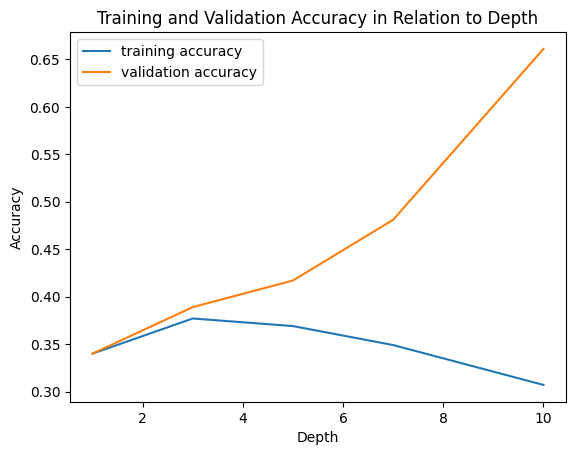

In [384]:
depths = [1,3,5,7,10]

def k_fold_validation(model, X, y, k=4):
    total_val_acc = 0
    total_train_acc = 0
    for i in range (1,k+1):
        left = int(len(X)*((i-1)*(1/k)))
        right = int(len(X)*((i)*(1/k)))
        X_fold_train = np.concatenate([X[:left],X[right:]])
        X_fold_test = X[left:right]
        y_fold_train = np.concatenate([y[:left],y[right:]])
        y_fold_test = y[left:right]

        model.fit(X_fold_train, y_fold_train)
        y_hat_test = model.predict(X_fold_test)
        y_hat_train = model.predict(X_fold_train)
        err_test = np.mean(y_hat_test != y_fold_test)
        err_train = np.mean(y_hat_train != y_fold_train)
        val_acc = 1 - err_test
        train_acc = 1 - err_train
        total_val_acc += val_acc
        total_train_acc += train_acc
    
    return round(total_val_acc / k, 3), round(total_train_acc / k, 3)

accuracies = None
for depth in depths:
    model = DecisionTree(depth)
    val_acc, train_acc = k_fold_validation(model, X_train, y_train, k=3)
    accs = np.array([val_acc, train_acc])
    accuracies = accs if accuracies is None else np.vstack((accuracies, accs))
    print(f"depth:{depth}, validation accuracy: {val_acc}, training accuracy: {train_acc}")

plt.plot(depths, accuracies[:,0], label="training accuracy")
plt.plot(depths, accuracies[:,1], label="validation accuracy")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy in Relation to Depth")
plt.legend()

Above is a great illustration of the fundamental trade-off. As expected, increasing depth increases training accuracy as we simply capture more of the training set. However, our validation accuracy increases initially but then starts to decrease. This is due to overfitting with increased depth. Lets move on and see how we can improve using a random forest.

## Random Tree
We will generate a random tree which differs from the decision tree in that it bootstraps the passed in X and y to better generalize. Our random forest will simply be a collection of random trees where we predict on the mode of all of their labels.

In [356]:
class RandomTree(DecisionTree):
    def __init__(self, max_depth):
        DecisionTree.__init__(self, max_depth=max_depth, random=True)

    def fit(self, X, y):
        n = X.shape[0]
        boostrap_indices = np.random.choice(n, n, replace=True)
        bootstrap_X = X[boostrap_indices]
        bootstrap_y = y[boostrap_indices]

        DecisionTree.fit(self, bootstrap_X, bootstrap_y)


class RandomForest:
    num_trees = 0
    max_depth = 0
    trees = []

    def __init__(self, num_trees, max_depth):
        self.num_trees = num_trees
        self.max_depth = max_depth

    def fit(self, X, y):
        for i in range(self.num_trees):
            tree = RandomTree(self.max_depth)
            tree.fit(X, y)
            self.trees.append(tree)

    def predict(self, X):
        y_pred = None
        for i in range(len(self.trees)):
            curr_pred = self.trees[i].predict(X)
            if(i == 0):
                y_pred = curr_pred
            else: 
                y_pred = np.vstack((y_pred, curr_pred))
        
        return mode(y_pred)[0].flatten()

Now let us create a couple random forests to tune the hyperparameters of depth and number of trees

In [357]:
best_num_trees = 0
best_depth = 0
best_acc = 0
forest_sizes = [1,3,5,10]
depths = [1,3,5,10]

for num_trees in forest_sizes:
    for depth in depths:
        random_forest = RandomForest(max_depth=depth, num_trees=num_trees)
        val_acc, train_acc = k_fold_validation(random_forest, X_train, y_train, k=4)
        print(f"depth: {depth}, trees: {num_trees}, validation accuracy: {val_acc}, training accuracy: {train_acc}")
        if(val_acc > best_acc):
            best_acc = val_acc
            best_depth = depth
            best_num_trees = num_trees

print(f"Best validation accuracy: {best_acc}, depth = {best_depth}, best num_trees = {best_num_trees}")

C:\Users\brian\AppData\Local\Temp\ipykernel_26388\2089471679.py:38: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return mode(y_pred)[0].flatten()


depth: 1, trees: 1, validation accuracy: 0.316, training accuracy: 0.307
depth: 3, trees: 1, validation accuracy: 0.348, training accuracy: 0.349
depth: 5, trees: 1, validation accuracy: 0.374, training accuracy: 0.376
depth: 10, trees: 1, validation accuracy: 0.403, training accuracy: 0.409
depth: 1, trees: 3, validation accuracy: 0.385, training accuracy: 0.389
depth: 3, trees: 3, validation accuracy: 0.394, training accuracy: 0.39
depth: 5, trees: 3, validation accuracy: 0.392, training accuracy: 0.395
depth: 10, trees: 3, validation accuracy: 0.408, training accuracy: 0.416
depth: 1, trees: 5, validation accuracy: 0.424, training accuracy: 0.426
depth: 3, trees: 5, validation accuracy: 0.409, training accuracy: 0.404
depth: 5, trees: 5, validation accuracy: 0.384, training accuracy: 0.386
depth: 10, trees: 5, validation accuracy: 0.407, training accuracy: 0.413
depth: 1, trees: 10, validation accuracy: 0.407, training accuracy: 0.41
depth: 3, trees: 10, validation accuracy: 0.389, 

Unlike the single decision tree, increased depth did not give a significantly higher training accuracy as random trees and random forests reduce the amount of overfitting.

As expected we are getting better accuracies with random forests but not by a large margin. Nonetheless, now that we have the best hyperparameters that we could find, we can run this model on our test set and see what our final test accuracy will be. Ideally it should be very close to the validation accuracy.

In [377]:
model = RandomForest(max_depth=best_depth, num_trees=best_num_trees)
model.fit(X_train, y_train)
y_hat_test = model.predict(X_test)
err_test = np.mean(y_hat_test != y_test)
test_acc = round(1 - err_test, 3)
print(f"Test accuracy: {test_acc} with depth={best_depth} and num_trees={best_num_trees}")

Test accuracy: 0.396 with depth=1 and num_trees=5


C:\Users\brian\AppData\Local\Temp\ipykernel_26388\2089471679.py:38: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return mode(y_pred)[0].flatten()


Our test accuracy of 0.396 is not far off from our validation and training error for that respective forest which is good to see. This is approximately a 0.08 increase in accuracy in comparison to baseline, so not great but still an improvement. With that, the conclusion we can draw is that Manhattan airbnb prices are absolutely unreasonable and make no sense. This conclusion may or may not be biased by the $2000 dollar bill one had to pay for 5 nights...

## Discussion and Conclusion
In all seriousness, there may be many reasons for the poor prediction score. The lack of compute resulted in using a small subset of the data with very limited hyperparameter tuning. The dataset itself could also be lacking very important features when it comes to price such as amenities, square footage, date, etc. If we could improve our procedure we would do more rigourous hyperparameter tuning as well as using more of the dataset. Focusing on the data, perhaps the bins we chose were not good ranges, but this is hard to tell without overfitting bins to the training set. Statistical analysis and removal of outliers would also be a good idea in the pre-processing stage, however we agreed it would out of scope for this project. Overall the development of the random forest model was a great learning experience (aside from the frustrating debugging after waiting for the model to train)!

## (Aside) Pre-built Random Forest
Lastly, lets take a look at what results we get from sklearn. The random forest from the sklearn package seems to perform similarly poorly which gives confidence that our random forest was coded properly. Surprisingly ours does perform better, though without looking through the exact implementation of sklearn it would be hard to tell why.

In [367]:
from sklearn import ensemble

forest = ensemble.RandomForestClassifier(n_estimators=5, max_depth=1, criterion="entropy")
forest.fit(X_train,y_train)
y_hat = forest.predict(X_train)
y_test_hat = forest.predict(X_test)
train_acc = round(1 - np.mean(y_hat != y_train), 3)
test_acc = round(1 - np.mean(y_test_hat != y_test), 3)
print(f"Test accuracy: {test_acc} training accuracy: {train_acc}")

Test accuracy: 0.384 training accuracy: 0.356
